In [74]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Summary: 
This notebook opens up the NOBM-OASIM dataset and runs a PCA/EOF analysis on normalized Rrs to determine modes of variability. PCs with a std lower than 0.1% of std of first PC are discarded, resulting in 8 PCs. The resulting 8 PC loadings are exported as .csv

# Open dataset

In [75]:
rrs_xds = xr.open_dataset('/glusteruser/awindled/all_NOBM_OASIM_data_2020.nc', decode_times=False)
rrs_xds

<xarray.Dataset>
Dimensions:         (months: 12, lat: 234, lon: 288, wavelength: 401)
Coordinates:
  * months          (months) float32 0.0 1.0 2.0 3.0 4.0 ... 8.0 9.0 10.0 11.0
  * lat             (lat) float32 -84.0 -83.33 -82.67 -82.0 ... 70.0 70.67 71.33
  * lon             (lon) float32 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * wavelength      (wavelength) int64 350 351 352 353 354 ... 747 748 749 750
    wv              (wavelength) int64 ...
Data variables: (12/42)
    tot             (months, lat, lon) float32 ...
    chl             (months, lat, lon) float32 ...
    dia             (months, lat, lon) float32 ...
    coc             (months, lat, lon) float32 ...
    cya             (months, lat, lon) float32 ...
    din             (months, lat, lon) float32 ...
    ...              ...
    coc_a           (wavelength, months, lat, lon) float32 ...
    coc_bb          (wavelength, months, lat, lon) float32 ...
    cdoc_a          (wavelength, months, lat, lon) float32 ...
    det_a           (wavelength, months, lat, lon) float32 ...
    det_bb          (wavelength, months, lat, lon) float32 ...
    pic_bb          (wavelength, months, lat, lon) float32 ...

In [76]:
rrs_xds.wavelength

<xarray.DataArray 'wavelength' (wavelength: 401)>
array([350, 351, 352, ..., 748, 749, 750])
Coordinates:
  * wavelength  (wavelength) int64 350 351 352 353 354 ... 746 747 748 749 750
    wv          (wavelength) int64 ...

# Normalize rrs and add as new variable
TODO: or should this be called standardized?

In [6]:
rrs_xds['rrs_norm'] = (rrs_xds.rrs - rrs_xds.rrs.mean()) / rrs_xds.rrs.std()
rrs_xds

<xarray.Dataset>
Dimensions:         (months: 12, lat: 234, lon: 288, wavelength: 401)
Coordinates:
  * months          (months) float32 0.0 1.0 2.0 3.0 4.0 ... 8.0 9.0 10.0 11.0
  * lat             (lat) float32 -84.0 -83.33 -82.67 -82.0 ... 70.0 70.67 71.33
  * lon             (lon) float32 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * wavelength      (wavelength) int64 350 351 352 353 354 ... 747 748 749 750
    wv              (wavelength) int64 ...
Data variables: (12/43)
    tot             (months, lat, lon) float32 ...
    chl             (months, lat, lon) float32 ...
    dia             (months, lat, lon) float32 ...
    coc             (months, lat, lon) float32 ...
    cya             (months, lat, lon) float32 ...
    din             (months, lat, lon) float32 ...
    ...              ...
    coc_bb          (wavelength, months, lat, lon) float32 ...
    cdoc_a          (wavelength, months, lat, lon) float32 ...
    det_a           (wavelength, months, lat, lon) float32 ...
    det_bb          (wavelength, months, lat, lon) float32 ...
    pic_bb          (wavelength, months, lat, lon) float32 ...
    rrs_norm        (wavelength, months, lat, lon) float64 nan nan ... nan nan

# Stack dataset and get rid of nans

In [7]:
rrs_norm_stacked = rrs_xds.rrs_norm.stack(z=("lat", "lon", "months"))
rrs_norm_stacked_no_nans = rrs_norm_stacked.dropna(dim='z', how='all')

rrs_norm_stacked_no_nans

<xarray.DataArray 'rrs_norm' (wavelength: 401, z: 488364)>
array([[ 0.71381059,  0.08793176,  0.00744206, ...,  0.3217765 ,
         0.34277058,  0.3528711 ],
       [ 0.72513853,  0.09318137,  0.01204307, ...,  0.32775978,
         0.34945046,  0.35995451],
       [ 0.73650729,  0.09848567,  0.01661268, ...,  0.3337546 ,
         0.35616321,  0.36705459],
       ...,
       [-0.99056016, -0.99905358, -1.00246036, ..., -0.9985635 ,
        -0.99794956, -0.99749812],
       [-0.99530621, -0.99221159, -1.00246036, ..., -0.99852198,
        -0.99791817, -0.99747686],
       [-0.99051342, -0.99560902, -1.00246036, ..., -0.99848007,
        -0.99788669, -0.99745559]])
Coordinates:
  * wavelength  (wavelength) int64 350 351 352 353 354 ... 746 747 748 749 750
    wv          (wavelength) int64 ...
  * z           (z) object MultiIndex
  * lat         (z) float32 -78.0 -78.0 -78.0 -78.0 ... 70.67 70.67 70.67 70.67
  * lon         (z) float32 -180.0 -180.0 -180.0 -180.0 ... 16.25 16.25 16.25
  * months      (z) float32 0.0 1.0 2.0 3.0 4.0 5.0 ... 7.0 8.0 9.0 10.0 11.0

In [8]:
#swapping axes for pca analysis
rrs_norm_stacked_no_nans = np.array(np.swapaxes(rrs_norm_stacked_no_nans, 0, 1))
print(rrs_norm_stacked_no_nans.shape)

(488364, 401)


# Perform PCA on ALL normalized Rrs data

In [9]:
from sklearn.decomposition import PCA

# Create and fit the PCA model
pca = PCA() 

In [10]:
scores = pca.fit_transform(rrs_norm_stacked_no_nans)
scores.shape #U #scores 
#represents amplitude of the EOF for each Rrs spectra 

(488364, 401)

In [11]:
loadings = pca.components_
loadings.shape #V #eigenvectors #rotation in each component
#EOF loadings- one loading for each wavelength 

(401, 401)

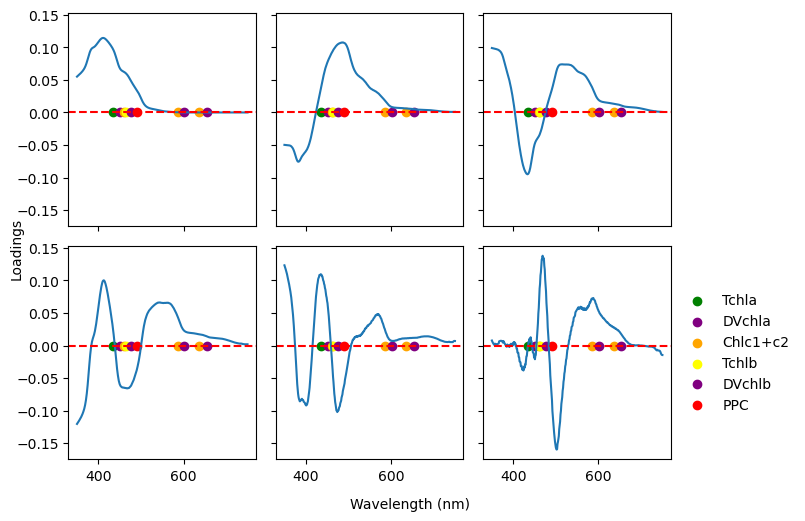

In [73]:
# Plots of the first 9 principal component loadings
fig, axs = plt.subplots(2, 3, figsize=(8, 5), sharex=True, sharey=True)
axs = axs.flatten()
wavelength = np.arange(350,751,1)

for i in range(6):
    axs[i].plot(wavelength, pca.components_[i, :], linestyle="-", marker="")
    axs[i].axhline(0, linestyle="--", color="red")
    #axs[i].set_xlabel("Wavelength (nm)")
    #axs[i].set_ylabel("Loadings")
    #axs[i].set_title(f"EOF {i+1}")
    axs[i].scatter(435, 0, color='green', label='Tchla') #Tchla
    axs[i].scatter(452, 0, color='purple', label='DVchla') #DVchla
    axs[i].scatter(461, 0, color='orange', label='Chlc1+c2') #Chlc1+c2
    axs[i].scatter(464, 0, color='yellow', label='Tchlb') #Tchlb
    axs[i].scatter(476, 0, color='purple', label='DVchlb') #DVchlb
    axs[i].scatter(490, 0, color='red', label='PPC') 
    axs[i].scatter(586, 0, color='orange') #Chlc1+c2
    axs[i].scatter(602, 0, color='purple') #DVchlb
    axs[i].scatter(636, 0, color='orange') #Chlc1+c2
    axs[i].scatter(654, 0, color='purple') #DVchlb


fig.text(0.5, -0.02, 'Wavelength (nm)', ha='center')
fig.text(0, 0.5, 'Loadings', va='center', rotation='vertical')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.tight_layout()
#plt.show()

plt.savefig('/glusteruser/awindled/PCC_OASIM_figs/PCA_plots.png', dpi=300) 


# Convert loadings to pandas dataframe

In [20]:
PC_column_names = []
for i in range(len(loadings)):
    name = str('PC' + str(i+1))
    PC_column_names.append(name)

In [21]:
loadings_dat = pd.DataFrame(loadings)
loadings_dat = loadings_dat.set_axis([PC_column_names], axis=1)
loadings_dat = loadings_dat.set_axis([wavelength], axis=0)
loadings_dat

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC392,PC393,PC394,PC395,PC396,PC397,PC398,PC399,PC400,PC401
350,0.055005,0.055595,0.056184,0.056776,0.057372,0.057974,0.058585,0.059204,0.059844,0.060504,...,-2.553331e-05,-2.646084e-05,-2.745877e-05,-2.891096e-05,-3.231162e-05,-3.714902e-05,-4.022529e-05,-4.248704e-05,-4.062586e-05,-3.845918e-05
351,-0.049796,-0.049860,-0.049911,-0.049952,-0.049987,-0.050018,-0.050051,-0.050215,-0.050264,-0.050328,...,7.889562e-04,7.973125e-04,8.002430e-04,8.170964e-04,8.450875e-04,8.669323e-04,8.809864e-04,8.851224e-04,8.900821e-04,8.923968e-04
352,0.098926,0.098782,0.098637,0.098496,0.098354,0.098211,0.098068,0.097807,0.097653,0.097491,...,1.119051e-03,1.103541e-03,1.086288e-03,1.057331e-03,1.034055e-03,9.755480e-04,9.068682e-04,8.469066e-04,8.024507e-04,7.741566e-04
353,-0.120409,-0.119454,-0.118471,-0.117459,-0.116416,-0.115342,-0.114230,-0.113238,-0.112041,-0.110789,...,2.194478e-03,2.030736e-03,1.920041e-03,1.890620e-03,1.885913e-03,1.972260e-03,1.998893e-03,2.015722e-03,1.927810e-03,1.914017e-03
354,0.123148,0.121144,0.119051,0.116859,0.114560,0.112167,0.109646,0.105997,0.103204,0.100285,...,5.284087e-03,5.160859e-03,5.166359e-03,5.192374e-03,5.285486e-03,5.945967e-03,6.636550e-03,6.944829e-03,7.056156e-03,6.956782e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,0.006164,-0.000132,0.003332,-0.001595,0.000212,-0.005240,-0.000307,-0.002313,-0.002506,-0.000493,...,-4.187731e-06,4.609991e-06,-2.966915e-06,1.907410e-06,-4.518035e-07,-1.641044e-06,1.178136e-06,1.373688e-06,-8.301199e-07,-2.749670e-06
747,-0.001991,0.002591,0.001718,-0.001795,0.000579,-0.003002,0.000490,0.000445,-0.000725,-0.002686,...,-6.208659e-07,8.442176e-07,2.067931e-06,2.573401e-06,1.277621e-06,9.387238e-07,1.129239e-06,1.346766e-06,-5.092757e-08,-2.539679e-07
748,0.003266,0.004642,0.002250,-0.003100,-0.004262,-0.000818,-0.003591,-0.000376,-0.003949,-0.005234,...,1.554009e-07,-2.382448e-06,1.155519e-06,-4.165815e-07,3.107758e-06,-6.333953e-07,1.615772e-06,-4.373246e-06,-7.618808e-08,-1.532639e-06
749,-0.002043,-0.000110,-0.001774,0.004298,-0.000565,0.003607,0.002535,-0.000262,0.000893,-0.006210,...,1.599688e-06,2.937014e-06,-1.136775e-06,8.773376e-07,1.087121e-06,1.302139e-06,-7.885246e-07,4.453205e-07,-1.738330e-06,1.183360e-06


# Truncate PCs based on std
### Following Lange and Bracher - PCs with std <= 0.001 (0.1%) times the std of first compoinent were omitted

In [22]:
PC1_std = np.std(scores[:,0])
print(PC1_std)

std_all = []
for i in range(0,401):
    std = np.std(scores[:,i])
    #print(std)
    std_all.append(std/PC1_std)
    if std >= PC1_std*0.001:
        print(i)

7.034946503462687
0
1
2
3
4
5
6
7


In [25]:
loadings_trun = loadings[:,0:8]
loadings_trun = pd.DataFrame(loadings_trun)
loadings_trun = loadings_trun.set_axis(loadings_dat.columns[0:8], axis=1)
loadings_trun

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.055005,0.055595,0.056184,0.056776,0.057372,0.057974,0.058585,0.059204
1,-0.049796,-0.049860,-0.049911,-0.049952,-0.049987,-0.050018,-0.050051,-0.050215
2,0.098926,0.098782,0.098637,0.098496,0.098354,0.098211,0.098068,0.097807
3,-0.120409,-0.119454,-0.118471,-0.117459,-0.116416,-0.115342,-0.114230,-0.113238
4,0.123148,0.121144,0.119051,0.116859,0.114560,0.112167,0.109646,0.105997
...,...,...,...,...,...,...,...,...
396,0.006164,-0.000132,0.003332,-0.001595,0.000212,-0.005240,-0.000307,-0.002313
397,-0.001991,0.002591,0.001718,-0.001795,0.000579,-0.003002,0.000490,0.000445
398,0.003266,0.004642,0.002250,-0.003100,-0.004262,-0.000818,-0.003591,-0.000376
399,-0.002043,-0.000110,-0.001774,0.004298,-0.000565,0.003607,0.002535,-0.000262


# Explained variance from each loading

In [24]:
np.around(pca.explained_variance_[0:8], 1)

array([49.5,  1.6,  0.4,  0.1,  0. ,  0. ,  0. ,  0. ])

# Exoprt truncated loadings as .csv

In [26]:
loadings_trun.to_csv('/glusteruser/awindled/loadings_trun.csv')
loadings_trun

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.055005,0.055595,0.056184,0.056776,0.057372,0.057974,0.058585,0.059204
1,-0.049796,-0.049860,-0.049911,-0.049952,-0.049987,-0.050018,-0.050051,-0.050215
2,0.098926,0.098782,0.098637,0.098496,0.098354,0.098211,0.098068,0.097807
3,-0.120409,-0.119454,-0.118471,-0.117459,-0.116416,-0.115342,-0.114230,-0.113238
4,0.123148,0.121144,0.119051,0.116859,0.114560,0.112167,0.109646,0.105997
...,...,...,...,...,...,...,...,...
396,0.006164,-0.000132,0.003332,-0.001595,0.000212,-0.005240,-0.000307,-0.002313
397,-0.001991,0.002591,0.001718,-0.001795,0.000579,-0.003002,0.000490,0.000445
398,0.003266,0.004642,0.002250,-0.003100,-0.004262,-0.000818,-0.003591,-0.000376
399,-0.002043,-0.000110,-0.001774,0.004298,-0.000565,0.003607,0.002535,-0.000262


In [158]:
loadings_trun = pd.read_csv('/glusteruser/awindled/loadings_trun.csv', index_col=0) 
loadings_trun.shape

(401, 8)

In [151]:
loadings_trun.iloc[0,0]

0.055005139708282

In [152]:
type(loadings_trun.iloc[0,0])

numpy.float64

In [157]:
loadings_trun.PC1.mode()

0     -0.473825
1     -0.369022
2     -0.212983
3     -0.185521
4     -0.151330
5     -0.150275
6     -0.143584
7     -0.136717
8     -0.120409
9     -0.117675
10    -0.102500
11    -0.087582
12    -0.084089
13    -0.062070
14    -0.060482
15    -0.057919
16    -0.057900
17    -0.057529
18    -0.057378
19    -0.055894
20    -0.052605
21    -0.052197
22    -0.052022
23    -0.049796
24    -0.049444
25    -0.048873
26    -0.048843
27    -0.047431
28    -0.045689
29    -0.045219
30    -0.044067
31    -0.043573
32    -0.043203
33    -0.042226
34    -0.041478
35    -0.040825
36    -0.040146
37    -0.039109
38    -0.038084
39    -0.037337
40    -0.037043
41    -0.036436
42    -0.034816
43    -0.034035
44    -0.029909
45    -0.028820
46    -0.028072
47    -0.027694
48    -0.027686
49    -0.027421
50    -0.027204
51    -0.026704
52    -0.025300
53    -0.024566
54    -0.022570
55    -0.021968
56    -0.021813
57    -0.021283
58    -0.021156
59    -0.020760
60    -0.019865
61    -0.019579
62    -0

In [149]:
loadings_trun[(loadings_trun == 0.0).any(axis=1)].index


Index([], dtype='int64')

<Axes: ylabel='Frequency'>

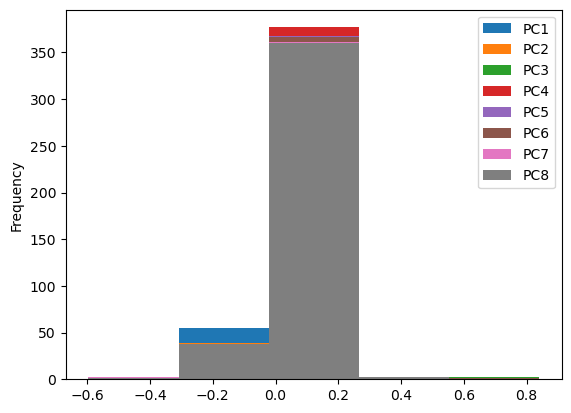

In [161]:
loadings_trun.plot.hist(bins=5)